In [39]:
import os
import rasterio
from rasterio import features
from rasterio.windows import Window
import fiona
import numpy as np
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [2]:
# Create path to data directory, make sure it exists
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"Data")
assert os.path.isdir

In [4]:
# Define paths to image file and shape files + make sure it exists
imgf = os.path.join(data_dir, "PDX_DEM_WGS84_UTM10N_Zm_INT16.tif")
assert os.path.isfile(imgf)

shpf = os.path.join(data_dir, "PDX_Neighborhoods_WGS84_UTM10N.shp")
assert os.path.isfile(shpf)

In [5]:
vec =  fiona.open(shpf, 'r')
ras = rasterio.open(imgf, 'r')

In [25]:
# Lets use the first record in the shape to start
poly = shape(vec[0]['geometry'])

# What is the name of the neighborhood
print(vec[0]['properties']['NAME'])

CATHEDRAL PARK


In [29]:
# Get bounds of polygon
w, s, e, n = poly.bounds

print(w, s, e, n)

517537.07627829857 5047017.287687072 520395.7140042724 5049513.14832079


In [53]:
# Lets turn the geotransform into a variable
gt = ras.transform

In [54]:
# lets find the pixels that match the upper left and lower right corners
ul = np.floor(~gt * (w, n)).astype(np.int16)
print (ul)

lr = np.floor(~gt * (e, s)).astype(np.int16)
print(lr)

[2664  449]
[2950  699]


In [49]:
# Remember we need to create a "Window" to tell rasterio what to read
# Window() takes (xoff, yoff, xsize, ysize) in pixel space as arguments
# to calculate xsize and ysize we can subtract ul from lr
xdist, ydist = lr-ul

# read the subset of the data into a numpy array
data = ras.read(1, window=Window(ul[0],ul[1],xdist,ydist))
data.shape

(250, 286)

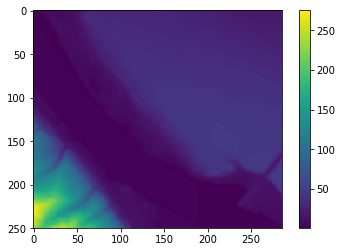

In [50]:
plt.imshow(data)
plt.colorbar()
plt.show()

In [57]:
# Lets create a new geotransform to rasterize the feature geometry to
# We know that we only need to modify the the original geotransform
# by changing the ulx and uly to the coordinates of the pixels we just used
# as the xoff,yoff (variable "ul") above
newx, newy = gt * ul
print(newx, newy)


# create an affine transform for the subset data
new_affine = rasterio.Affine(gt[0], gt[1], newx, gt[3], gt[4], newy)

517533.2197361471 5049518.957242726


In [58]:
# rasterize the geometry
mask = features.rasterize(
    [(poly, 1)],
    out_shape=data.shape,
    transform=new_affine,
    all_touched=True,
    dtype=np.uint8)

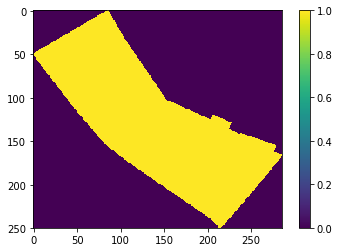

In [59]:
plt.imshow(mask)
plt.colorbar()
plt.show()

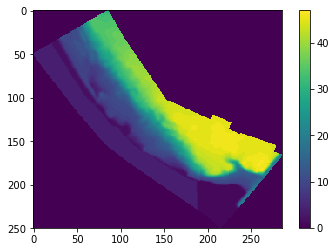

In [66]:
plt.imshow(data*mask)
plt.colorbar()
plt.show()